# 频繁模式与关联规则挖掘

github地址：https://github.com/Chen-Jiake/DataMiningAssignment/tree/main/Assignment2

## 1.数据集处理

In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

In [2]:
path="/home/fc/code/WineReviews/winemag-data_first150k.csv"

In [3]:
data = pd.read_csv(path)

In [4]:
data

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...,...
150925,150925,Italy,Many people feel Fiano represents southern Ita...,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,150926,France,"Offers an intriguing nose with ginger, lime an...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,150927,Italy,This classic example comes from a cru vineyard...,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,150928,France,"A perfect salmon shade, with scents of peaches...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


数据集包括了标称属性：country、designation、province、region_1、region_2、variety、winery，数值属性：points、price，首先对数据进行处理：
1. 由于description是个人主观的评价，不做考虑。
2. country、province、region_1、region_2都是对葡萄产地的描述，而province、region_1、region_2种类过于复杂，所以这四个属性里只对country进行考虑
3. 由于winery和designation的种类数量分别为14810和30622，过于复杂，所以也不做考虑。

综上，对country、points、price和winery进行挖掘

In [6]:
data = data[['country','variety','points','price']]
data =data.dropna() #除去缺失值
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137230 entries, 0 to 150929
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   country  137230 non-null  object 
 1   variety  137230 non-null  object 
 2   points   137230 non-null  int64  
 3   price    137230 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.2+ MB


对数值属性points和price进行处理：

In [7]:
data[['points','price']].describe()

,points,price
count,137230.000000,137230.000000
mean,87.788035,33.132019
std,3.221572,36.323072
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


根据它们的Q1、Q2、Q3，可以将points和price分成4个等级
- points可以分为：(0,86], (86,88],(88,90],(90,100]
- price可以分为：(0,16],(16,24],(24,40],(40,2300]

In [8]:
bin = [0,86,88,90,100]
data['points'] = pd.cut(data['points'],bin)
data['points'] = data['points'].astype('str')
bin = [0,16,24,40,2300]
data['price'] = pd.cut(data['price'],bin)
data['price'] = data['price'].astype('str')

In [9]:
data

,country,variety,points,price
0,US,Cabernet Sauvignon,"(90, 100]","(40, 2300]"
1,Spain,Tinta de Toro,"(90, 100]","(40, 2300]"
2,US,Sauvignon Blanc,"(90, 100]","(40, 2300]"
3,US,Pinot Noir,"(90, 100]","(40, 2300]"
4,France,Provence red blend,"(90, 100]","(40, 2300]"
...,...,...,...,...
150925,Italy,White Blend,"(90, 100]","(16, 24]"
150926,France,Champagne Blend,"(90, 100]","(24, 40]"
150927,Italy,White Blend,"(90, 100]","(16, 24]"
150928,France,Champagne Blend,"(88, 90]","(40, 2300]"


## 2.找出频繁模式

使用python机器学习包mlxtend中的apriori算法，首先需要把数据转化为mlxtend库要求的格式：

In [10]:
def deal(data):
    return data.to_list()
data_list = data.apply(deal,axis=1).tolist()

In [11]:
te = TransactionEncoder()
data_tf = te.fit_transform(data_list)
data = pd.DataFrame(data_tf,columns=te.columns_)

转化得到的数据如下所示：

In [12]:
data

,"(0, 16]","(0, 86]","(16, 24]","(24, 40]","(40, 2300]","(86, 88]","(88, 90]","(90, 100]",Agiorgitiko,Aglianico,...,Xinomavro,Xynisteri,Yapincak,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Žilavka
0,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137225,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
137226,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
137227,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
137228,False,False,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


使用apriori函数求频繁项集，将最小支持度min_support设置为0.1

In [13]:
frequent_itemsets = apriori(data, min_support=0.1, use_colnames=True)

In [14]:
frequent_itemsets

,support,itemsets
0,0.278095,"((0, 16])"
1,0.350973,"((0, 86])"
2,0.226284,"((16, 24])"
3,0.267412,"((24, 40])"
4,0.228208,"((40, 2300])"
5,0.255476,"((86, 88])"
6,0.189164,"((88, 90])"
7,0.204387,"((90, 100])"
8,0.100379,(Chardonnay)
9,0.107739,(France)


## 3.导出关联规则

使用mlxtend中的association_rules方法导出关联规则，将最小置信度设置为0.4

In [15]:
rules =  association_rules(frequent_itemsets, metric ='confidence', min_threshold = 0.4)

得到的关联规则如下所示，其中 antecedents 列为规则先导项，consequents 列为则后继项，support 列为规则支持度，confidence 列为规则置信度

In [16]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"((0, 86])","((0, 16])",0.350973,0.278095,0.180099,0.513143,1.845205,0.082495,1.482785
1,"((0, 16])","((0, 86])",0.278095,0.350973,0.180099,0.647617,1.845205,0.082495,1.841822
2,"((0, 86])",(US),0.350973,0.452809,0.164119,0.467611,1.032688,0.005195,1.027802
3,"((24, 40])",(US),0.267412,0.452809,0.157896,0.590457,1.303986,0.036809,1.336101
4,"((90, 100])","((40, 2300])",0.204387,0.228208,0.125060,0.611880,2.681235,0.078417,1.988537
5,"((40, 2300])","((90, 100])",0.228208,0.204387,0.125060,0.548009,2.681235,0.078417,1.760242
6,"((40, 2300])",(US),0.228208,0.452809,0.113255,0.496280,1.096003,0.009920,1.086300
7,"((86, 88])",(US),0.255476,0.452809,0.106915,0.418495,0.924218,-0.008767,0.940990
8,"((90, 100])",(US),0.204387,0.452809,0.104656,0.512051,1.130831,0.012108,1.121409


## 4.对规则进行评价

利用 lift 和 all confidence 对规则进行评价

In [17]:
def all_conf(x):
    return x.support/max(x['antecedent support'],x['consequent support'])

In [18]:
all_conf_list = []
rule_list = []
for _, row in rules.iterrows():
    all_conf_list.append(all_conf(row))
    rule_list.append(str(row['antecedents'])[10:-1] + " -> " + str(row['consequents'])[10:-1])
rules['all confidence'] = all_conf_list
rules['rule'] = rule_list

得到的结果如下所示：

In [19]:
rules = rules[['rule','support','confidence','lift','all confidence']]
rules

,rule,support,confidence,lift,all confidence
0,"{'(0, 86]'} -> {'(0, 16]'}",0.180099,0.513143,1.845205,0.513143
1,"{'(0, 16]'} -> {'(0, 86]'}",0.180099,0.647617,1.845205,0.513143
2,"{'(0, 86]'} -> {'US'}",0.164119,0.467611,1.032688,0.362445
3,"{'(24, 40]'} -> {'US'}",0.157896,0.590457,1.303986,0.348702
4,"{'(90, 100]'} -> {'(40, 2300]'}",0.125060,0.611880,2.681235,0.548009
5,"{'(40, 2300]'} -> {'(90, 100]'}",0.125060,0.548009,2.681235,0.548009
6,"{'(40, 2300]'} -> {'US'}",0.113255,0.496280,1.096003,0.250117
7,"{'(86, 88]'} -> {'US'}",0.106915,0.418495,0.924218,0.236116
8,"{'(90, 100]'} -> {'US'}",0.104656,0.512051,1.130831,0.231127


## 5.可视化展示

分别对规则的 support、confidence、lift 和 all confidence 进行可视化

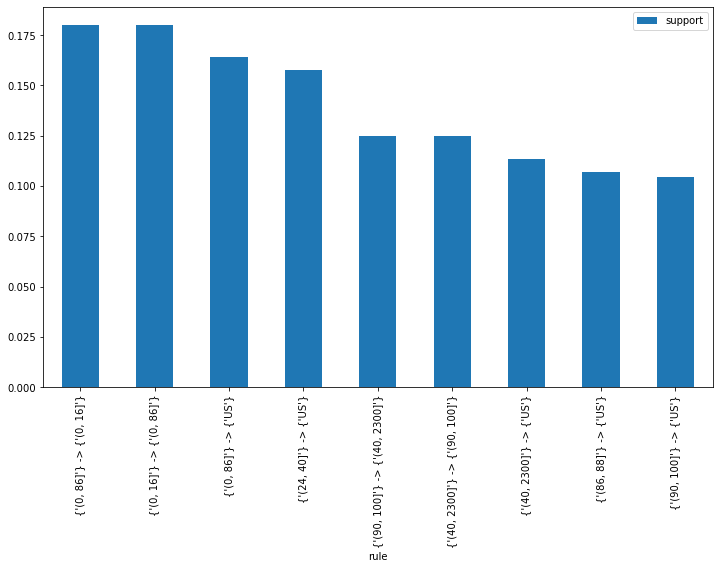

In [20]:
rules.plot(x='rule', y='support', kind='bar',figsize=(12,7))

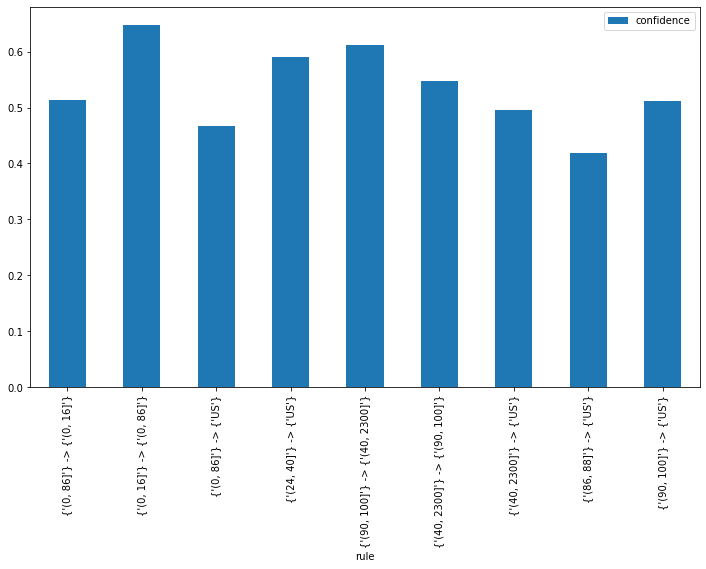

In [21]:
rules.plot(x='rule', y='confidence', kind='bar',figsize=(12,7))

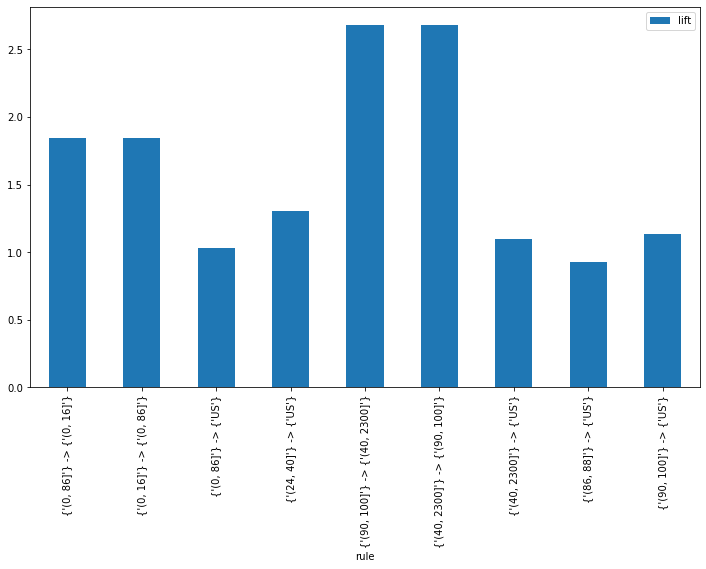

In [22]:
rules.plot(x='rule', y='lift', kind='bar',figsize=(12,7))

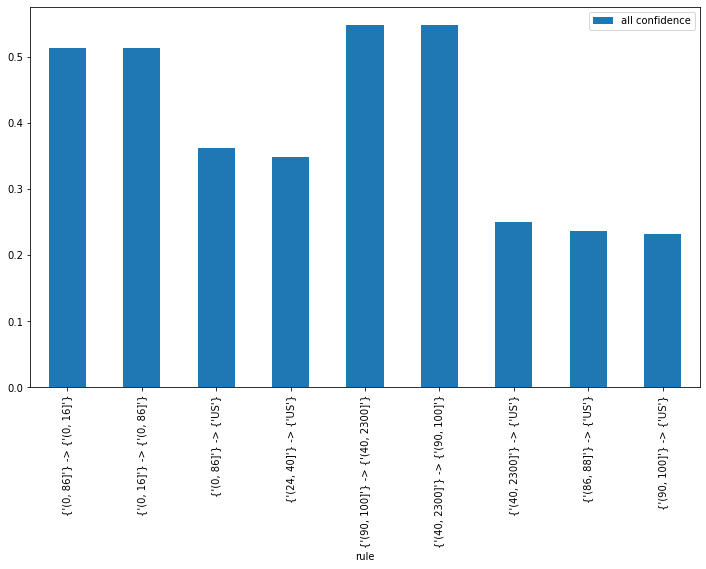

In [23]:
rules.plot(x='rule', y='all confidence', kind='bar',figsize=(12,7))

## 6.对挖掘结果进行分析

根据得到的强关联规则进行分析，可以得到以下的结果：
1. 当红酒的价格很低时，它的评分也往往很低；同样的，当红酒的评分很低时，它的价格也往往很低。而当红酒的价格或评分很高时，与之对应的评分或价格也相应的很高。
2. 价格较高的红酒的产地为美国的可能性较高